In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
#Define who is a child, female adult and male adult:
def child_female_male(passenger):
    Age, Sex = passenger
    if Age < 16:
        return 'child'
    else:
        return Sex
    
# nieuwe kolommen    # leeftijdscategorieën toevoegen
def leeftijdscategorie(leeftijd):
    if leeftijd < 16:
        return 1
    elif 16 <= leeftijd <= 34:
        return 2
    elif 35 <= leeftijd <= 49:
        return 3
    elif 50 <= leeftijd <= 64:
        return 4
    else:
        return 5

In [4]:
# Laad de datasets (pas de bestandsnamen en paden aan naar jouw situatie)
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Vul ontbrekende waarden in voor 'Age' met de mediaan (of een andere geschikte strategie)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())

df= pd.DataFrame({'Leeftijd': train_df['Age']})
train_df['Age_categories'] = df['Leeftijd'].apply(leeftijdscategorie)

df= pd.DataFrame({'Leeftijd': test_df['Age']})
test_df['Age_categories'] = df['Leeftijd'].apply(leeftijdscategorie)

train_df['Embarked'].fillna('S', inplace=True)
test_df['Embarked'].fillna('S', inplace=True)

#Replace the one NaN value in test set 'Fare'
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

#Create new column to define if passenger was child/female/male
train_df['Type'] = train_df[['Age', 'Sex']].apply(child_female_male, axis = 1)
test_df['Type'] = test_df[['Age', 'Sex']].apply(child_female_male, axis = 1)

# Look who had family and who didn't
train_df['Family'] = (train_df['Parch'] + train_df['SibSp']).apply(lambda x: 1 if x > 0 else 0)
test_df['Family'] = (test_df['Parch'] + test_df['SibSp']).apply(lambda x: 1 if x > 0 else 0)

# travel alone, of met gezelschap
train_df['Travel_budy'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Travel_budy'] = test_df['SibSp'] + test_df['Parch'] + 1
train_df['IsAlone'] = (train_df['Travel_budy'] == 1).astype(int)
test_df['IsAlone'] = (test_df['Travel_budy'] == 1).astype(int)

# Say a small family is less than 5 whilst a large family contains 5 or more
train_df['Small_fam'] = (train_df['Parch'] + train_df['SibSp'] + 1).apply(lambda x: 1 if x < 5 else 0)
test_df['Small_fam'] = (test_df['Parch'] + test_df['SibSp'] + 1).apply(lambda x: 1 if x < 5 else 0)

#Convert Fare to int value
train_df['Fare']= train_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

# Maak kopieën van de originele kolommen 'Embarked' en 'Type'
train_df['Embarked_original'] = train_df['Embarked']
test_df['Embarked_original'] = test_df['Embarked']

train_df['Type_original'] = train_df['Type']
test_df['Type_original'] = test_df['Type']

# One-hot encoding voor categorische variabelen
train_df = pd.get_dummies(train_df, columns=['Embarked', 'Type'], prefix=['Embarked', 'Type'])
test_df = pd.get_dummies(test_df, columns=['Embarked', 'Type'], prefix=['Embarked', 'Type'])

# Naam naar titels geven
train_df['Title'] = train_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rare":6}
train_df['Title_code'] = train_df['Title'].map(lambda x: title_mapping.get(x, 6))

# Naam naar titels geven
test_df['Title'] = test_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare":5}
test_df['Title_code'] = test_df['Title'].map(lambda x: title_mapping.get(x, 5))

train_df


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

C:\Users\qvled\AppData\Local\Temp\ipykernel_24732\3469309538.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=survived_corr.index, y=survived_corr.values, palette='coolwarm')


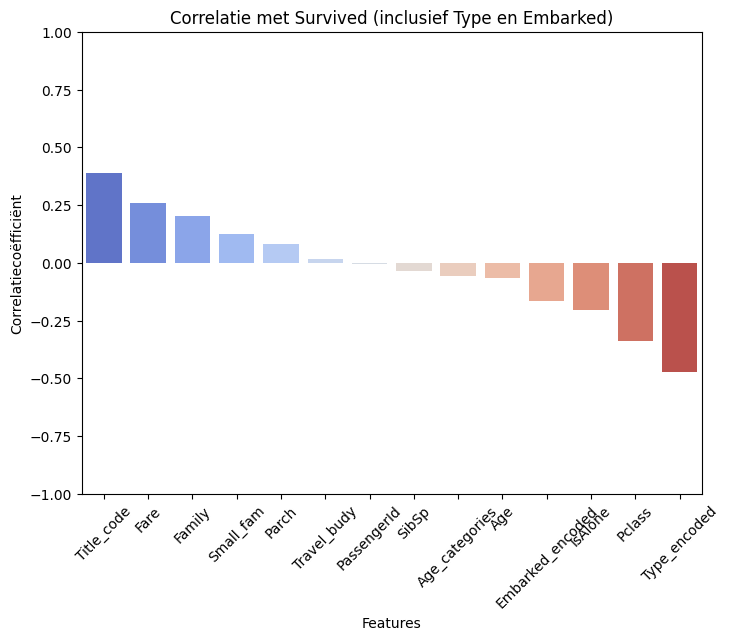

In [ ]:
# Zorg ervoor dat categorische kolommen worden gecodeerd
train_df['Type_encoded'] = train_df['Type_original'].astype('category').cat.codes.astype(int)
train_df['Embarked_encoded'] = train_df['Embarked_original'].astype('category').cat.codes.astype(int)

# Zorg ervoor dat categorische kolommen worden gecodeerd
test_df['Type_encoded'] = test_df['Type_original'].astype('category').cat.codes.astype(int)
test_df['Embarked_encoded'] = test_df['Embarked_original'].astype('category').cat.codes.astype(int)

# Voeg de gecodeerde kolommen toe aan de numerieke dataset
numeric_cols = train_df.select_dtypes(include=['float64', 'int64', 'int32', 'int16'])

# Bereken de correlatiematrix
corr = numeric_cols.corr()

# Filter alleen de correlaties met 'Survived', exclusief 'Survived' zelf
survived_corr = corr['Survived'].drop('Survived').sort_values(ascending=False)

# Plot de correlaties met 'Survived'
plt.figure(figsize=(8, 6))
sns.barplot(x=survived_corr.index, y=survived_corr.values, palette='coolwarm')
plt.title("Correlatie met Survived (inclusief Type en Embarked)")
plt.ylabel("Correlatiecoëfficiënt")
plt.xlabel("Features")
plt.ylim(-1, 1)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Voorbereiding van de data
X = train_df.drop(columns=['Embarked_original','Type_original','Title','Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId', 'Parch', 'SibSp', 'Survived'], axis=1)
y = train_df['Survived']

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Splits de data in train- en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


Beste aantal buren: 2
Hoogste nauwkeurigheid: 0.7443946188340808


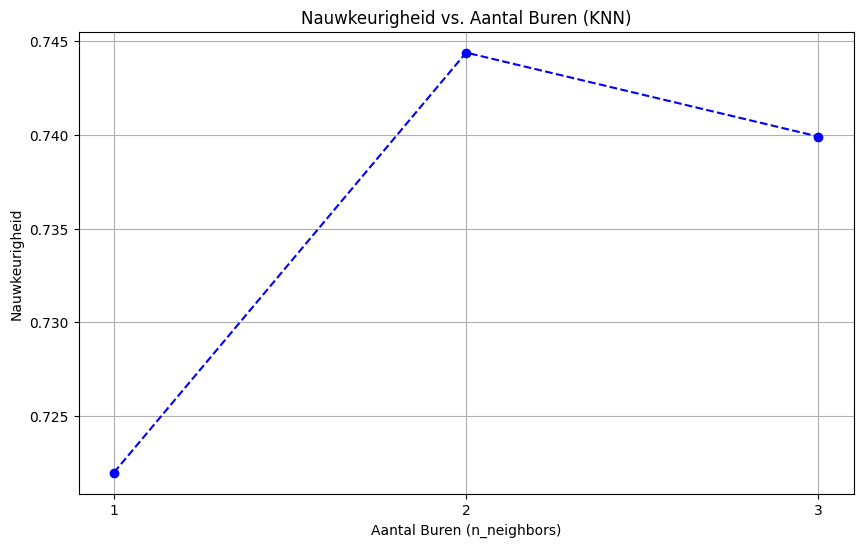

In [ ]:
from sklearn.metrics import accuracy_score

# Test verschillende waarden van n_neighbors
accuracies = []
neighbors_range = range(1, 4)  # Test n_neighbors van 1 tot 20

for n in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

# Vind het beste aantal buren
best_n = neighbors_range[accuracies.index(max(accuracies))]
print(f"Beste aantal buren: {best_n}")
print(f"Hoogste nauwkeurigheid: {max(accuracies)}")

# Plot de nauwkeurigheid voor verschillende waarden van n_neighbors
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, accuracies, marker='o', linestyle='--', color='b')
plt.title('Nauwkeurigheid vs. Aantal Buren (KNN)')
plt.xlabel('Aantal Buren (n_neighbors)')
plt.ylabel('Nauwkeurigheid')
plt.xticks(neighbors_range)
plt.grid()
plt.show()

In [ ]:
# Train een KNN-model met 3 buren
knn_model = KNeighborsClassifier(n_neighbors=4)

# Zorg ervoor dat de scaler wordt getraind op de trainingsdata
knn_scaler = StandardScaler()
X_train_knn_scaled = pd.DataFrame(knn_scaler.fit_transform(X_train), columns=X_train.columns)  # Fit en transformeer de trainingsdata
X_test_knn_scaled = pd.DataFrame(knn_scaler.transform(X_test), columns=X_test.columns)         # Transformeer de testdata

# Train het KNN-model met een DataFrame
knn_model.fit(X_train_knn_scaled, y_train)

# Maak voorspellingen op de testset
knn_predictions = knn_model.predict(X_test_knn_scaled)

# Bereken de nauwkeurigheid
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

# Werk met een kopie van test_df
test_df_knn = test_df.copy()

# Zorg ervoor dat test_df dezelfde preprocessing heeft ondergaan als train_df
X_test_df_knn = test_df_knn.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId', 'Embarked_original', 'Type_original'], errors='ignore')

# Zorg ervoor dat de kolommen in test_df overeenkomen met die in X_train
X_test_df_knn = X_test_df_knn.reindex(columns=X_train.columns, fill_value=0)

# Schaal de testdata (gebruik dezelfde scaler als voor X_train)
X_test_df_knn_scaled = pd.DataFrame(knn_scaler.transform(X_test_df_knn), columns=X_test_df_knn.columns)

# Maak voorspellingen op test_df
test_predictions_knn = knn_model.predict(X_test_df_knn_scaled)

# Voeg de voorspellingen toe aan test_df
test_df_knn['Survived'] = test_predictions_knn

# Sla de resultaten op in een CSV-bestand
output_file_knn = "titanic_predictions_knn_3_neighbors.csv"
test_df_knn[['PassengerId', 'Survived']].to_csv(output_file_knn, index=False)

print(f"Voorspellingen opgeslagen in {output_file_knn}")
print(f"Aantal buren gebruikt in KNN-model: {knn_model.n_neighbors}")

KNN Accuracy: 0.8116591928251121
Voorspellingen opgeslagen in titanic_predictions_knn_3_neighbors.csv
Aantal buren gebruikt in KNN-model: 4


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# Train een lineair regressiemodel
linear_model = LinearRegression()

# Zorg ervoor dat de scaler wordt getraind op de trainingsdata
linear_scaler = StandardScaler()
X_train_linear_scaled = pd.DataFrame(linear_scaler.fit_transform(X_train), columns=X_train.columns)  # Fit en transformeer de trainingsdata
X_test_linear_scaled = pd.DataFrame(linear_scaler.transform(X_test), columns=X_test.columns)         # Transformeer de testdata

# Train het lineaire regressiemodel
linear_model.fit(X_train_linear_scaled, y_train)

# Maak voorspellingen op de trainings-testset
linear_predictions_raw = linear_model.predict(X_test_linear_scaled)

# Afronden naar 0 of 1 voor classificatie
linear_predictions = [1 if pred >= 0.88 else 0 for pred in linear_predictions_raw]

# Evaluatie
linear_accuracy = accuracy_score(y_test, linear_predictions)
print("Accuracy (Lineaire Regressie):", linear_accuracy)

# Werk met een kopie van test_df
test_df_linear = test_df.copy()

# Zorg ervoor dat test_df dezelfde preprocessing heeft ondergaan als train_df
X_test_df_linear = test_df_linear.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId', 'Survived'], errors='ignore')

# Zorg ervoor dat de kolommen in test_df overeenkomen met die in X_train
X_test_df_linear = X_test_df_linear.reindex(columns=X_train.columns, fill_value=0)

# Schaal de testdata (gebruik dezelfde scaler als voor X_train)
X_test_df_linear_scaled = pd.DataFrame(linear_scaler.transform(X_test_df_linear), columns=X_test_df_linear.columns)

# Maak voorspellingen op de echte testdata
test_predictions_linear_raw = linear_model.predict(X_test_df_linear_scaled)
test_predictions_linear = [1 if pred >= 0.6 else 0 for pred in test_predictions_linear_raw]

# Voeg de voorspellingen toe aan test_df
test_df_linear['Survived'] = test_predictions_linear

# Sla de resultaten op in een CSV-bestand
output_file_linear = "titanic_lineaire_regressie_predictions.csv"
test_df_linear[['PassengerId', 'Survived']].to_csv(output_file_linear, index=False)

print(f"Voorspellingen opgeslagen in {output_file_linear}")

Accuracy (Lineaire Regressie): 0.7130044843049327
Voorspellingen opgeslagen in titanic_lineaire_regressie_predictions.csv


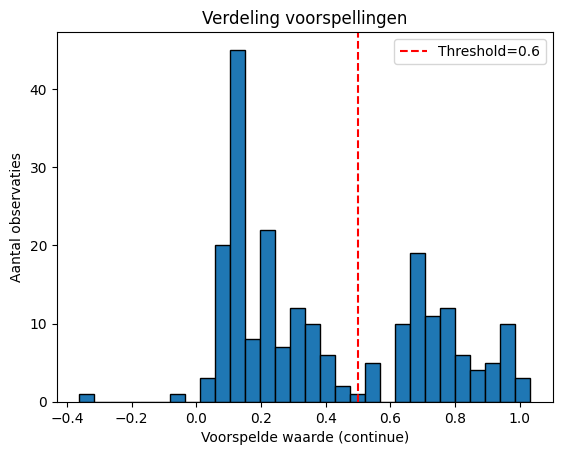

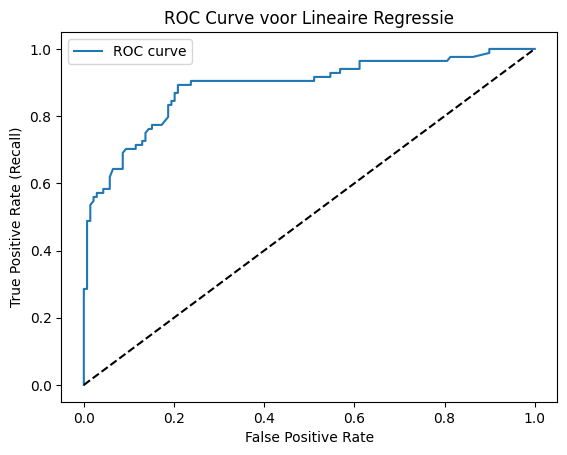

ROC AUC Score: 0.8875899280575539


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Zorg ervoor dat de ruwe voorspellingen van het lineaire regressiemodel beschikbaar zijn
test_predictions_linear_raw = model3.predict(X_test_scaled)  # Gebruik de geschaalde testdata

# Plot de verdeling van de voorspellingen
plt.hist(test_predictions_linear_raw, bins=30, edgecolor='k')
plt.axvline(0.5, color='r', linestyle='--', label='Threshold=0.6')
plt.legend()
plt.title("Verdeling voorspellingen")
plt.xlabel("Voorspelde waarde (continue)")
plt.ylabel("Aantal observaties")
plt.show()

# Bereken de ROC-curve
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_linear_raw)

# Plot de ROC-curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # Willekeurig gokken-lijn
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve voor Lineaire Regressie')
plt.legend()
plt.show()

# Bereken de AUC-score
auc = roc_auc_score(y_test, test_predictions_linear_raw)
print("ROC AUC Score:", auc)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

thresholds = np.linspace(0.1, 0.9, 50)
accuracies = []
f1_scores = []

for thresh in thresholds:
    preds_thresh = (predictions_continuous >= thresh).astype(int)
    accuracies.append(accuracy_score(y_test, preds_thresh))
    f1_scores.append(f1_score(y_test, preds_thresh))

best_thresh_acc = thresholds[np.argmax(accuracies)]
best_thresh_f1 = thresholds[np.argmax(f1_scores)]

print(f"Beste threshold volgens Accuracy: {best_thresh_acc}")
print(f"Beste threshold volgens F1-score: {best_thresh_f1}")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# Train een logistisch regressiemodel
logistic_model = LogisticRegression(max_iter=1000)

# Zorg ervoor dat de scaler wordt getraind op de trainingsdata
logistic_scaler = StandardScaler()
X_train_logistic_scaled = pd.DataFrame(logistic_scaler.fit_transform(X_train), columns=X_train.columns)  # Fit en transformeer de trainingsdata
X_test_logistic_scaled = pd.DataFrame(logistic_scaler.transform(X_test), columns=X_test.columns)         # Transformeer de testdata

# Train het logistische regressiemodel
logistic_model.fit(X_train_logistic_scaled, y_train)

# Maak voorspellingen op de trainings-testset
logistic_predictions = logistic_model.predict(X_test_logistic_scaled)

# Evaluatie
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("Accuracy (Logistische Regressie):", logistic_accuracy)

# Werk met een kopie van test_df
test_df_logistic = test_df.copy()

# Zorg ervoor dat test_df dezelfde preprocessing heeft ondergaan als train_df
X_test_df_logistic = test_df_logistic.drop(columns=['Title', 'Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId', 'Parch', 'SibSp'], axis=1)

# Controleer of er ontbrekende waarden zijn in X_test_df_logistic en vul deze alleen voor numerieke kolommen
numeric_cols_logistic = X_test_df_logistic.select_dtypes(include=['float64', 'int64', 'int32', 'int16'])
X_test_df_logistic[numeric_cols_logistic.columns] = numeric_cols_logistic.fillna(numeric_cols_logistic.mean())

# Zorg ervoor dat de kolommen in test_df overeenkomen met die in X_train
X_test_df_logistic = X_test_df_logistic.reindex(columns=X_train.columns, fill_value=0)

# Schaal de testdata (gebruik dezelfde scaler als voor X_train)
X_test_df_logistic_scaled = pd.DataFrame(logistic_scaler.transform(X_test_df_logistic), columns=X_test_df_logistic.columns)

# Maak voorspellingen op test_df
test_predictions_logistic = logistic_model.predict(X_test_df_logistic_scaled)

# Voeg de voorspellingen toe aan test_df
test_df_logistic['Survived'] = test_predictions_logistic

# Sla de resultaten op in een CSV-bestand
output_file_logistic = "titanic_logistische_regressie_predictions.csv"
test_df_logistic[['PassengerId', 'Survived']].to_csv(output_file_logistic, index=False)

print(f"Voorspellingen opgeslagen in {output_file_logistic}")

Accuracy (Logistische Regressie): 0.8161434977578476
Voorspellingen opgeslagen in titanic_logistische_regressie_predictions.csv
